In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
grid_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'compressed_shuffle_cancer_type',
    'gene'
).resolve()

grid_unimodal_results_dir = Path(
    cfg.results_dirs['mutation'],
    'methylation_results_shuffle_cancer_type',
    'gene'
)

bayes_opt_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'bayes_opt',
    'gene'
).resolve()

mlp_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'test_mlp',
    'gene'
).resolve()

In [3]:
# load raw data
grid_results_df = au.load_stratified_prediction_results(grid_results_dir, 'gene')

# drop TET2 for now
grid_results_df = grid_results_df[~(grid_results_df.identifier.isin(['TP53', 'IDH1', 'TET2']))]
grid_results_df['model'] = 'elasticnet, grid'

# make sure that we have data for all data types and for two replicates (random seeds)
print(grid_results_df.shape)
print(grid_results_df.seed.unique())
print(grid_results_df.identifier.unique())
print(grid_results_df.training_data.unique())
grid_results_df.head()

(768, 10)
[ 1 42]
['EGFR' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_27k.me_450k' 'expression.me_450k' 'expression.me_27k'
 'me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,model
0,1.00000,1.00000,EGFR,expression.me_27k.me_450k,shuffled,1,train,0,gene,"elasticnet, grid"
1,0.55618,0.13931,EGFR,expression.me_27k.me_450k,shuffled,1,test,0,gene,"elasticnet, grid"
2,0.50538,0.13090,EGFR,expression.me_27k.me_450k,shuffled,1,cv,0,gene,"elasticnet, grid"
3,0.99988,0.99918,EGFR,expression.me_27k.me_450k,shuffled,1,train,1,gene,"elasticnet, grid"
4,0.52160,0.12380,EGFR,expression.me_27k.me_450k,shuffled,1,test,1,gene,"elasticnet, grid"


In [4]:
# load expression and me_27k results
u_results_df = au.load_compressed_prediction_results(grid_unimodal_results_dir, 'gene')
genes = grid_results_df.identifier.unique()
u_results_df = u_results_df[(u_results_df.n_dims == 5000) &
                            (u_results_df.identifier.isin(genes))].copy()
u_results_df.drop(columns='n_dims', inplace=True)
u_results_df['model'] = 'elasticnet, grid'

# make sure data loaded matches our expectations
print(u_results_df.shape)
print(u_results_df.seed.unique())
print(u_results_df.identifier.unique())
print(u_results_df.training_data.unique())
u_results_df.head()

(576, 10)
[42  1]
['EGFR' 'PIK3CA' 'SETD2' 'KRAS']
['me_27k' 'expression' 'me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,model
0,0.98763,0.90701,EGFR,me_27k,signal,42,train,0,gene,"elasticnet, grid"
1,0.74957,0.37237,EGFR,me_27k,signal,42,test,0,gene,"elasticnet, grid"
2,0.73280,0.34552,EGFR,me_27k,signal,42,cv,0,gene,"elasticnet, grid"
3,0.99502,0.95957,EGFR,me_27k,signal,42,train,1,gene,"elasticnet, grid"
4,0.80799,0.45281,EGFR,me_27k,signal,42,test,1,gene,"elasticnet, grid"


In [5]:
grid_results_df = pd.concat((
    grid_results_df, u_results_df
))
group_df = (grid_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,experiment,model
identifier,training_data,,,,,,,,
EGFR,expression,48,48,48,48,48,48,48,48


In [6]:
# load raw data
bayes_opt_results_df = au.load_stratified_prediction_results(
    bayes_opt_results_dir, 'gene')

bayes_opt_results_df = bayes_opt_results_df[~(bayes_opt_results_df.identifier.isin(['TP53', 'IDH1', 'TET2']))]
bayes_opt_results_df = bayes_opt_results_df[~(bayes_opt_results_df.training_data.isin(['expression']))].copy()
bayes_opt_results_df['model'] = 'elasticnet, bayes'

# make sure that we have data for all data types and for two replicates (random seeds)
print(bayes_opt_results_df.shape)
print(bayes_opt_results_df.seed.unique())
print(bayes_opt_results_df.identifier.unique())
print(bayes_opt_results_df.training_data.unique())
bayes_opt_results_df.head()

(768, 10)
[42  1]
['EGFR' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_27k.me_450k' 'expression.me_27k' 'expression.me_450k'
 'me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,model
0,1.00000,1.00000,EGFR,expression.me_27k.me_450k,shuffled,42,train,3,gene,"elasticnet, bayes"
1,0.50210,0.13081,EGFR,expression.me_27k.me_450k,shuffled,42,test,3,gene,"elasticnet, bayes"
2,0.53442,0.13455,EGFR,expression.me_27k.me_450k,shuffled,42,cv,3,gene,"elasticnet, bayes"
0,0.99951,0.99643,EGFR,expression.me_27k,signal,42,train,1,gene,"elasticnet, bayes"
1,0.85040,0.51732,EGFR,expression.me_27k,signal,42,test,1,gene,"elasticnet, bayes"


In [7]:
# load expression and me_27k results
bayes_u_results_df = au.load_compressed_prediction_results(
    bayes_opt_results_dir, 'gene')

# filter to genes/dims we're using here
bayes_u_results_df = bayes_u_results_df[
    (bayes_u_results_df.n_dims == 5000) &
    (bayes_u_results_df.identifier.isin(genes))
].copy()
bayes_u_results_df.drop(columns='n_dims', inplace=True)
bayes_u_results_df['model'] = 'elasticnet, bayes'

# make sure data loaded matches our expectations
print(bayes_u_results_df.shape)
print(bayes_u_results_df.seed.unique())
print(bayes_u_results_df.identifier.unique())
print(bayes_u_results_df.training_data.unique())
bayes_u_results_df.head()

(576, 10)
[42  1]
['EGFR' 'PIK3CA' 'SETD2' 'KRAS']
['me_450k' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,model
0,0.58058,0.15535,EGFR,me_450k,shuffled,42,train,1,gene,"elasticnet, bayes"
1,0.52584,0.12973,EGFR,me_450k,shuffled,42,test,1,gene,"elasticnet, bayes"
2,0.50072,0.12844,EGFR,me_450k,shuffled,42,cv,1,gene,"elasticnet, bayes"
0,0.99996,0.99971,EGFR,expression,signal,1,train,1,gene,"elasticnet, bayes"
1,0.82751,0.54328,EGFR,expression,signal,1,test,1,gene,"elasticnet, bayes"


In [8]:
bayes_opt_results_df = pd.concat((
    bayes_opt_results_df, bayes_u_results_df
))
group_df = (bayes_opt_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,experiment,model
identifier,training_data,,,,,,,,
EGFR,expression,48,48,48,48,48,48,48,48


In [9]:
# load raw data
mlp_results_df = au.load_stratified_prediction_results(
    mlp_results_dir, 'gene')

mlp_results_df['model'] = 'mlp, random'

# make sure that we have data for all data types and for two replicates (random seeds)
print(mlp_results_df.shape)
print(mlp_results_df.seed.unique())
print(mlp_results_df.identifier.unique())
print(mlp_results_df.training_data.unique())
mlp_results_df.head()

(768, 10)
[ 1 42]
['EGFR' 'PIK3CA' 'SETD2' 'KRAS']
['me_27k.me_450k' 'expression.me_27k' 'expression.me_450k'
 'expression.me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,model
0,1.00000,1.00000,EGFR,me_27k.me_450k,shuffled,1,train,0,gene,"mlp, random"
1,0.52770,0.12829,EGFR,me_27k.me_450k,shuffled,1,test,0,gene,"mlp, random"
2,1.00000,1.00000,EGFR,me_27k.me_450k,shuffled,1,cv,0,gene,"mlp, random"
3,0.99233,0.96013,EGFR,me_27k.me_450k,shuffled,1,train,1,gene,"mlp, random"
4,0.51920,0.11135,EGFR,me_27k.me_450k,shuffled,1,test,1,gene,"mlp, random"


In [10]:
group_df = (mlp_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,experiment,model
identifier,training_data,,,,,,,,
EGFR,expression.me_27k,48,48,48,48,48,48,48,48


In [11]:
results_df = pd.concat((
    grid_results_df, bayes_opt_results_df, mlp_results_df
))

print(results_df.shape)
results_df.head()

(3456, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,model
0,1.00000,1.00000,EGFR,expression.me_27k.me_450k,shuffled,1,train,0,gene,"elasticnet, grid"
1,0.55618,0.13931,EGFR,expression.me_27k.me_450k,shuffled,1,test,0,gene,"elasticnet, grid"
2,0.50538,0.13090,EGFR,expression.me_27k.me_450k,shuffled,1,cv,0,gene,"elasticnet, grid"
3,0.99988,0.99918,EGFR,expression.me_27k.me_450k,shuffled,1,train,1,gene,"elasticnet, grid"
4,0.52160,0.12380,EGFR,expression.me_27k.me_450k,shuffled,1,test,1,gene,"elasticnet, grid"


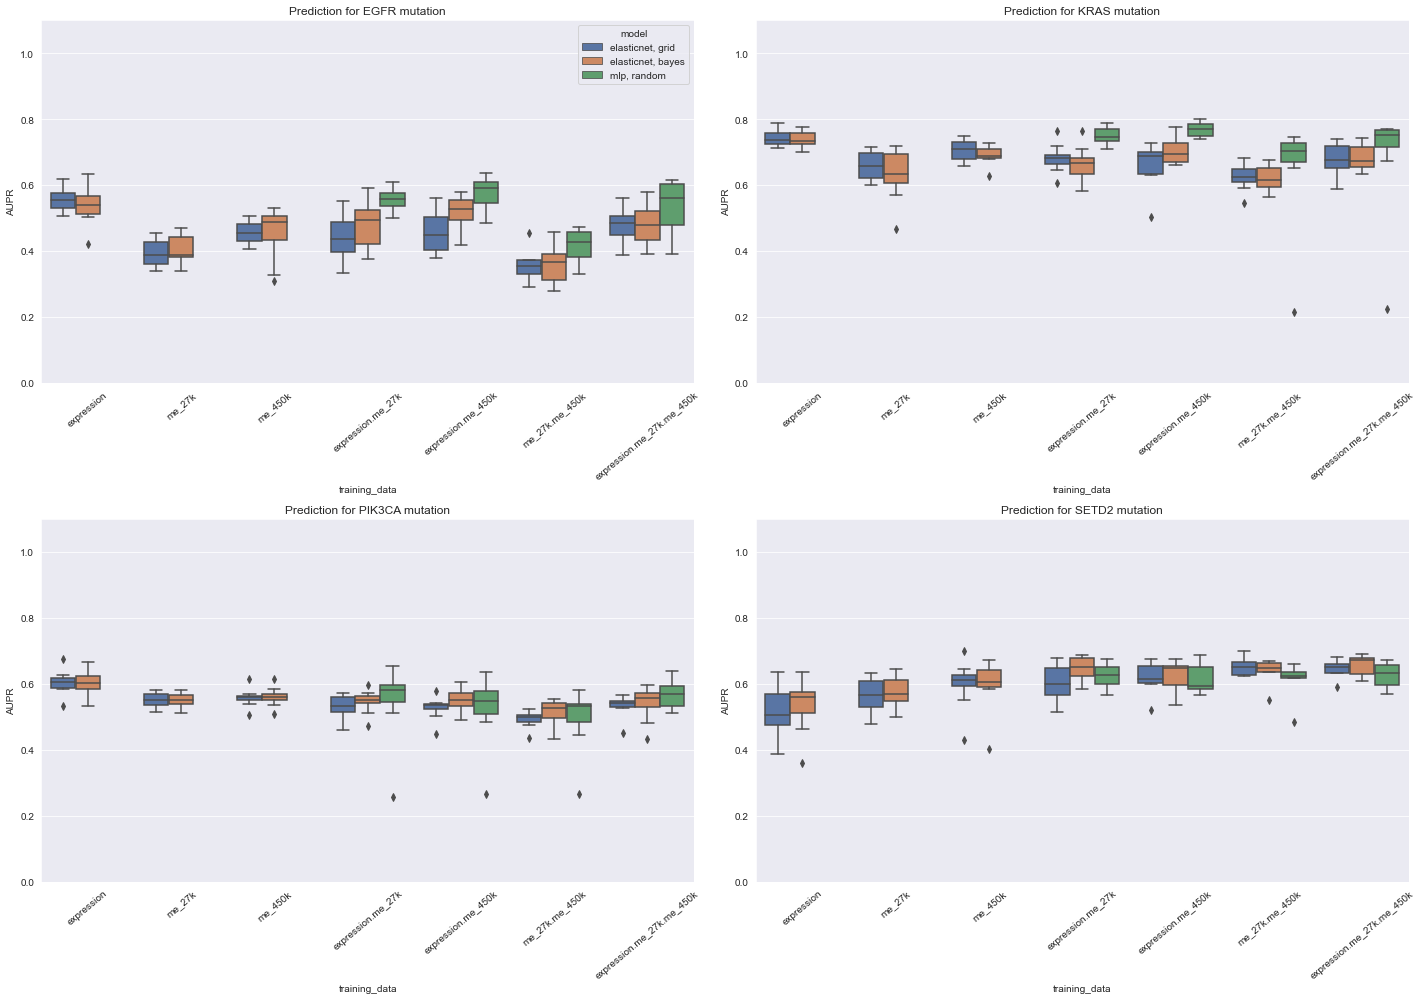

In [12]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 14)})
fig, axarr = plt.subplots(2, 2)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)

data_order =['expression',
             'me_27k',
             'me_450k',
             'expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

for ix, gene in enumerate(results_df.identifier.unique()):
    ax = axarr[ix // 2, ix % 2]
    plot_df = results_df[(results_df.identifier == gene) &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
    sns.boxplot(data=plot_df, x='training_data', y='aupr',
                order=data_order, hue='model', ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_ylabel('AUPR')
    ax.set_ylim(0.0, 1.1)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
    if ix != 0:
        ax.legend_.remove()
        
plt.tight_layout()